In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [23]:
# load dataset
# Transform to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='.././data', train=True, download=True, transform=transform)

# Splitting dataset into two parts: 0-4 and 5-9
def split_dataset(dataset):
    indices_0_4 = []
    indices_5_9 = []

    for i in range(len(dataset)):
        label = dataset[i][1]
        if label < 5:
            indices_0_4.append(i)
        else:
            indices_5_9.append(i)

    subset_0_4 = Subset(dataset, indices_0_4)
    subset_5_9 = Subset(dataset, indices_5_9)

    return subset_0_4, subset_5_9

subset_0_4, subset_5_9 = split_dataset(mnist_dataset)

# Create data loaders for the two subsets
batch_size = 64  # You can adjust the batch size as needed

full_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
dataloader_0_4 = DataLoader(subset_0_4, batch_size=batch_size, shuffle=True)
dataloader_5_9 = DataLoader(subset_5_9, batch_size=batch_size, shuffle=True)

In [5]:
for idx, sample in enumerate(dataloader_0_4):
    break

In [28]:
class CustomNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNetwork, self).__init__()
        self.weight1 = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.bias1 = nn.Parameter(torch.Tensor(hidden_size))

        self.weight2 = nn.Parameter(torch.Tensor(output_size, hidden_size))
        self.bias2 = nn.Parameter(torch.Tensor(output_size))

        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weight1)
        nn.init.constant_(self.bias1, 0)
        nn.init.xavier_uniform_(self.weight2)
        nn.init.constant_(self.bias2, 0)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(F.linear(x, self.weight1, self.bias1))
        x = F.linear(x, self.weight2, self.bias2)
        return F.log_softmax(x, dim=1)

net1 = CustomNetwork(784, 128, 10)
net2 = CustomNetwork(784, 128, 10)

In [29]:
loss_function = nn.CrossEntropyLoss()

optimizer1 = optim.SGD(net1.parameters(), lr=1, weight_decay=0.001)
optimizer2 = optim.SGD(net2.parameters(), lr=1, weight_decay=0.001)

def train_network(network, dataloader, optimizer, epochs=10):
    network.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for data in dataloader:
            inputs, labels = data
            optimizer.zero_grad()

            outputs = network(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100 * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%')

    return epoch_losses, epoch_accuracies



In [30]:
loss_history_1, accuracy_history_1 = train_network(net1, dataloader_0_4, optimizer1)

Epoch 1, Loss: 0.203, Accuracy: 94.53%
Epoch 2, Loss: 0.108, Accuracy: 96.83%
Epoch 3, Loss: 0.099, Accuracy: 97.11%
Epoch 4, Loss: 0.094, Accuracy: 97.25%
Epoch 5, Loss: 0.090, Accuracy: 97.35%
Epoch 6, Loss: 0.087, Accuracy: 97.50%
Epoch 7, Loss: 0.086, Accuracy: 97.61%
Epoch 8, Loss: 0.084, Accuracy: 97.55%
Epoch 9, Loss: 0.082, Accuracy: 97.71%
Epoch 10, Loss: 0.081, Accuracy: 97.71%


In [31]:
loss_history_2, accuracy_history_2 = train_network(net2, dataloader_5_9, optimizer2)

Epoch 1, Loss: 0.311, Accuracy: 90.56%
Epoch 2, Loss: 0.159, Accuracy: 95.06%
Epoch 3, Loss: 0.138, Accuracy: 95.73%
Epoch 4, Loss: 0.129, Accuracy: 96.00%
Epoch 5, Loss: 0.126, Accuracy: 96.14%
Epoch 6, Loss: 0.124, Accuracy: 96.19%
Epoch 7, Loss: 0.118, Accuracy: 96.48%
Epoch 8, Loss: 0.116, Accuracy: 96.62%
Epoch 9, Loss: 0.114, Accuracy: 96.57%
Epoch 10, Loss: 0.114, Accuracy: 96.61%


In [32]:
def plot_metrics(loss_history, accuracy_history, title):
    epochs = range(1, 11)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, 'r', label='Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, 'b', label='Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

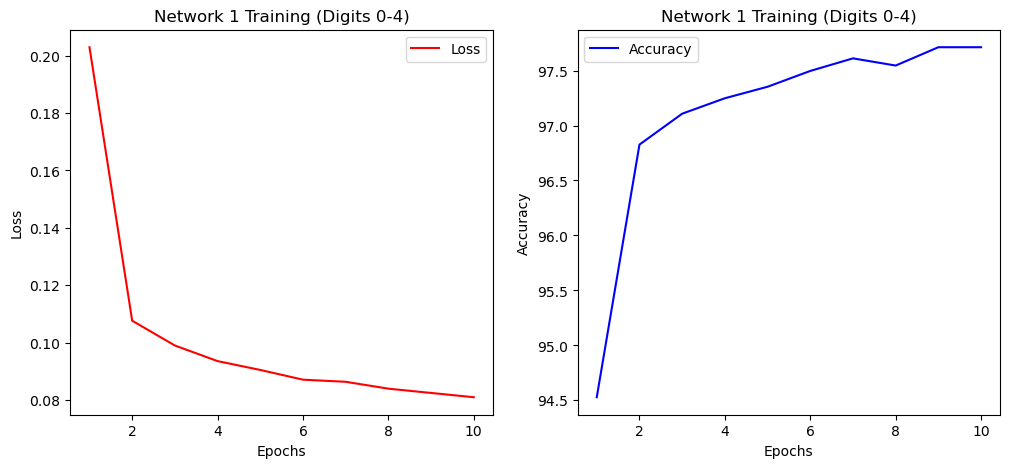

In [33]:
plot_metrics(loss_history_1, accuracy_history_1, 'Network 1 Training (Digits 0-4)')

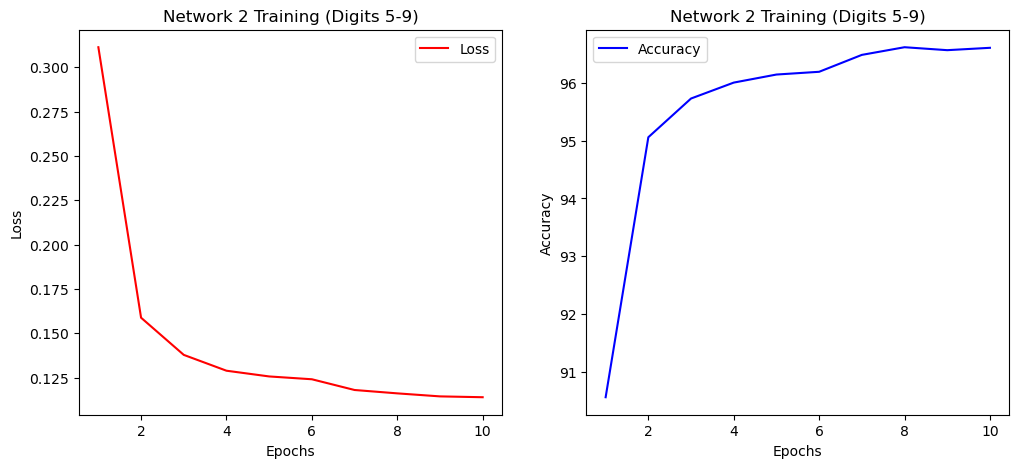

In [34]:
# Plot for Network 2 (Digits 5-9)
plot_metrics(loss_history_2, accuracy_history_2, 'Network 2 Training (Digits 5-9)')

In [22]:
def evaluate_model(model, dataloader):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# eval net1 on digits 5-9
loss_1, accuracy_1 = evaluate_model(net1, dataloader_5_9)
print(f'Network 1 - Loss: {loss_1:.3f}, Accuracy: {accuracy_1:.2f}%')

# eval net2 on digits 0-4
loss_2, accuracy_2 = evaluate_model(net2, dataloader_0_4)
print(f'Network 2 - Loss: {loss_2:.3f}, Accuracy: {accuracy_2:.2f}%')

Network 1 - Loss: 8.078, Accuracy: 0.00%
Network 2 - Loss: 7.912, Accuracy: 0.00%


In [21]:
# third network of average weights
net3 = CustomNetwork(784, 128, 10)

with torch.no_grad():
    for param1, param2, param3 in zip(net1.parameters(), net2.parameters(), net3.parameters()):
        param3.data.copy_((param1.data + param2.data) / 2)

In [24]:
loss_net3, accuracy_net3 = evaluate_model(net3, full_dataloader)
print(f'Net3 - Loss: {loss_net3:.3f}, Accuracy: {accuracy_net3:.2f}%')

Net3 - Loss: 1.303, Accuracy: 61.27%


In [27]:
# train the model for one epoch
optimizer3 = optim.SGD(net3.parameters(), lr=1, weight_decay=0.001)
loss_history_3, accuracy_history_3 = train_network(net3, full_dataloader, optimizer3, epochs=1)

Epoch 1, Loss: 0.304, Accuracy: 91.23%
